In [1]:
import numpy as np
import pandas as pd
from FundSelection import FundSelection
from Portfolio import Portfolio


PORTFOLIO_YEARS = 6
N_DAYS = 252  # trading days in a year
N_PORTFOLIOS = 1000000
RISK_FREE_RATE = 0.0375  # 3.75%  

fund_selection = [
    #FundSelection('JupiterMerian Glb Eq AbsRt I £ H Acc'),
    #FundSelection('Prem Miton Tellworth UK Sel Fd - Cl AAcc'),
    #FundSelection('JPM Europe Equity Absolute Alpha C (perf) (dist) - GBP (hedged)'), #, 0.09), #  0.1),
    #FundSelection('Man High Yield Opports Profl Acc C'), #,0.1), 
    #FundSelection('Man Sterling Corp Bd Profl Acc C'), #,0.1), # only has 47 monnths of data
    #FundSelection('Schroder High Yield Opportunities Z Acc'),
    #FundSelection('Aegon High Yield Bond GBP B Acc')
    # Man Dynamic Income

    FundSelection('YFS Argonaut Absolute Return I GBP Acc'),
    #FundSelection('Ranmore Global Equity Investor GBP'), #0.59 Correlated with global tracker
    #FundSelection('MFS Meridian Contrarian Value W1 GBP'), # 0.74 Correlated with global tracker
    #FundSelection('Orbis OEIC Global Balanced Standard'), # 0.73 Correlated with global tracker
    #FundSelection('FAST - Global Fund Y-PF-ACC-GBP'), # 0.49 Correlated with global tracker
    FundSelection('WisdomTree Physical Gold GBP Daily Hdgd'),
    FundSelection('iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP'),
    FundSelection('FAST - Global Fund Y-PF-ACC-GBP'), # 0.49 Correlated with global tracker

    #FundSelection('Winton Trend UCITS I GBP Acc'),
    #FundSelection('BH Macro GBP Ord'),
    
    #FundSelection('Fidelity Global Technology W-Acc-GBP'),
    #FundSelection('UBS FTSE RAFI Developed 1000 Index C Acc'),
    #FundSelection('Vanguard FTSE AllWld HiDivYld ETF USDAcc GBP'),
    #FundSelection('Artemis Global Income I Acc'),
    #FundSelection('Artemis SmartGARP Glb EM Eq I Acc GBP')

]

benchmark = [
    FundSelection('Ranmore Global Equity Investor GBP', 0.25),

    #FundSelection('L&G Global 100 Index I Acc', 0.13),
    FundSelection('Fidelity Global Technology W-Acc-GBP', 0.13),

    FundSelection('MFS Meridian Contrarian Value W1 GBP', 0.06),
    FundSelection('FAST - Global Fund Y-PF-ACC-GBP', 0.06),
    FundSelection('YFS Argonaut Absolute Return I GBP Acc', 0.10),
    FundSelection('BH Macro GBP Ord', 0.10),
    FundSelection('WisdomTree Physical Gold GBP Daily Hdgd', 0.10),
    FundSelection('Winton Trend UCITS I GBP Acc', 0.05),
    FundSelection('iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP',0.05),
    FundSelection('JupiterMerian Glb Eq AbsRt I £ H Acc', 0.05),
    FundSelection('Prem Miton Tellworth UK Sel Fd - Cl AAcc', 0.05)
]

portfolio = Portfolio(fund_selection, benchmark, PORTFOLIO_YEARS)

returns_df = portfolio.adjusted_returns
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

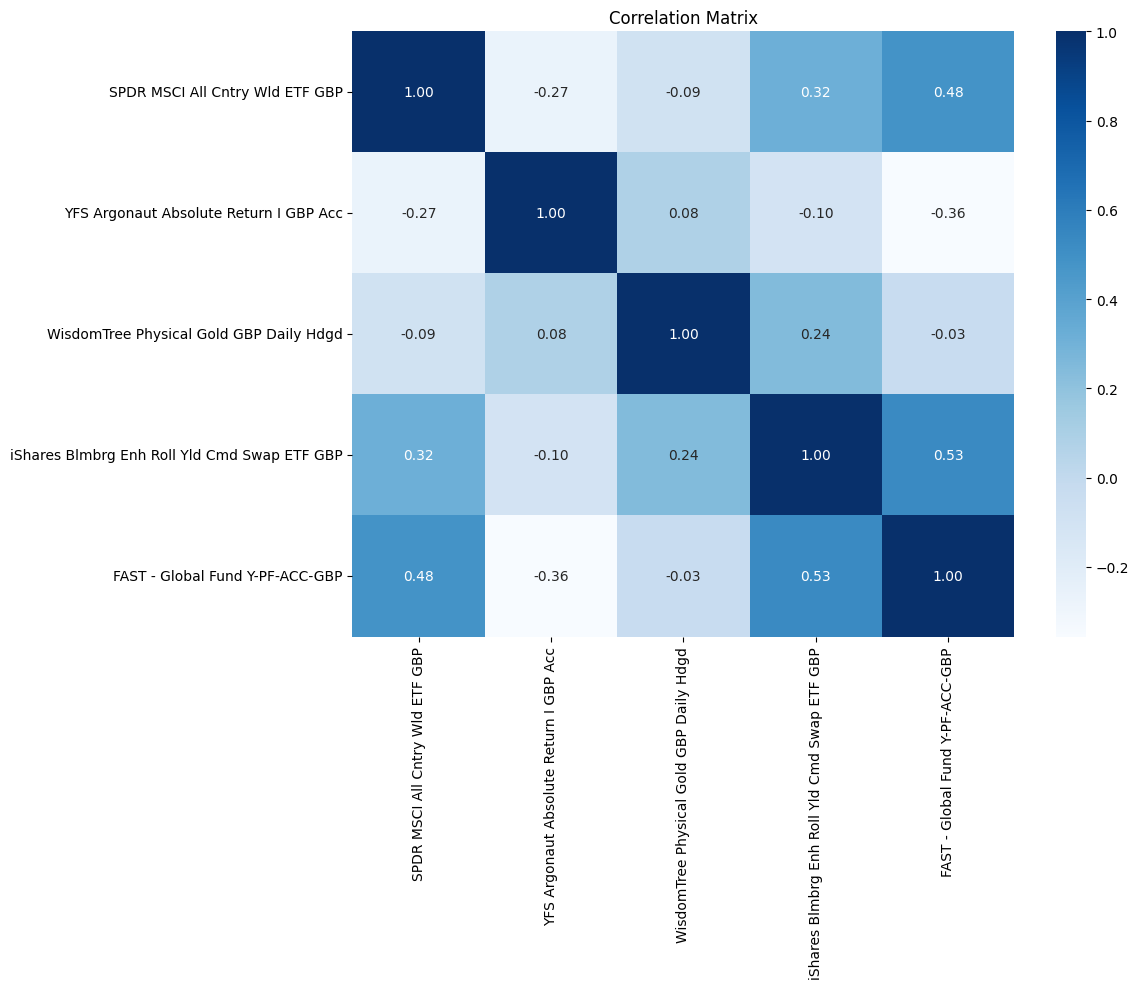

In [2]:
# Calculation Correlation Matrix
import seaborn as sns
import matplotlib.pyplot as plt

funds_with_global_tracker = [FundSelection('SPDR MSCI All Cntry Wld ETF GBP')] + fund_selection 
correlation_portfolio = Portfolio(funds_with_global_tracker, benchmark, PORTFOLIO_YEARS)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_portfolio.correlation_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [3]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, len(fund_selection)))
weights /= np.sum(weights, axis=1)[:, np.newaxis]

portf_rtns = np.dot(weights, avg_returns)
portf_vol = []

for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, np.dot(cov_mat, weights[i]))))

portf_vol = np.array(portf_vol)
portf_sharpe_ratio = (portf_rtns - RISK_FREE_RATE) / portf_vol

portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [4]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []
portf_rtns_ef = np.linspace(portf_results_df.returns.min(),
                            portf_results_df.returns.max(),
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)
for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

C:\Users\Pandelus\AppData\Local\Temp\ipykernel_26224\1191931292.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=avg_returns[asset_index],


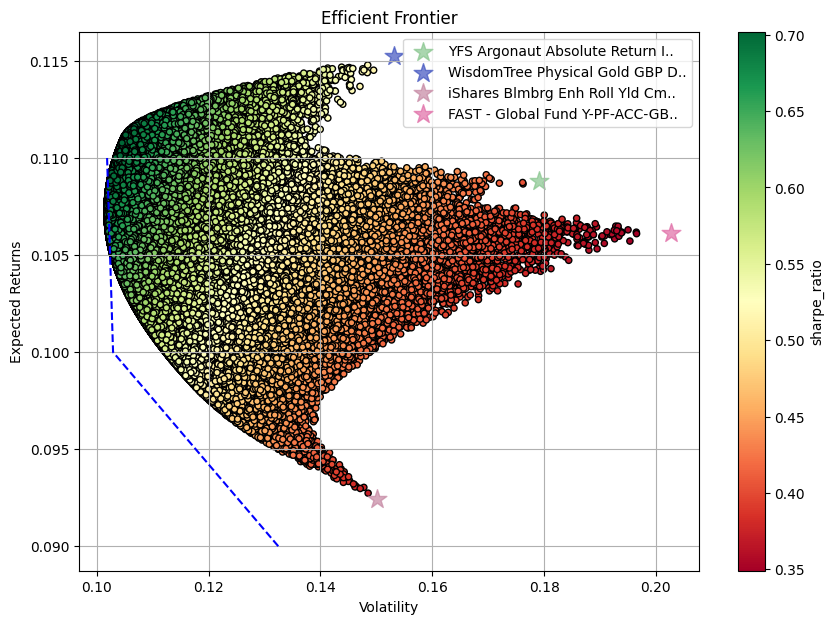

In [5]:
from matplotlib import pyplot as plt
from colorhash import ColorHash

MARKS = ['o', 'X', 'd', '*']
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax, figsize=(10, 7), grid=True)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(len(fund_selection)):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
               y=avg_returns[asset_index],
               marker='*',
               s=200,
               alpha=0.7,
               color=ColorHash(fund_selection[asset_index].name).hex,
               label=fund_selection[asset_index].name[:30]+'..')
ax.legend()

In [6]:
print('---- Maximum Sharpe ratio portfolio ----')
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
fund_names = [fund.name for fund in fund_selection]

for index, value in max_sharpe_portf.items():
   print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(fund_names, weights[max_sharpe_ind]):
   print(f'{100*y:.2f}% {x}\n', end="", flush=True)

print('\n')   

print('---- Minimum Volatility portfolio ----')
min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]
for index, value in min_vol_portf.items():
   print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
for x, y in zip(fund_names, weights[min_vol_ind]):
   print(f'{100*y:.2f}% {x}\n', end="", flush=True)   


---- Maximum Sharpe ratio portfolio ----
returns: 11.07% volatility: 10.43% sharpe_ratio: 70.19% 
Weights
30.78% YFS Argonaut Absolute Return I GBP Acc
44.35% WisdomTree Physical Gold GBP Daily Hdgd
2.19% iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP
22.68% FAST - Global Fund Y-PF-ACC-GBP


---- Minimum Volatility portfolio ----
returns: 10.72% volatility: 10.18% sharpe_ratio: 68.48% 29.88% YFS Argonaut Absolute Return I GBP Acc
32.08% WisdomTree Physical Gold GBP Daily Hdgd
19.17% iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP
18.88% FAST - Global Fund Y-PF-ACC-GBP


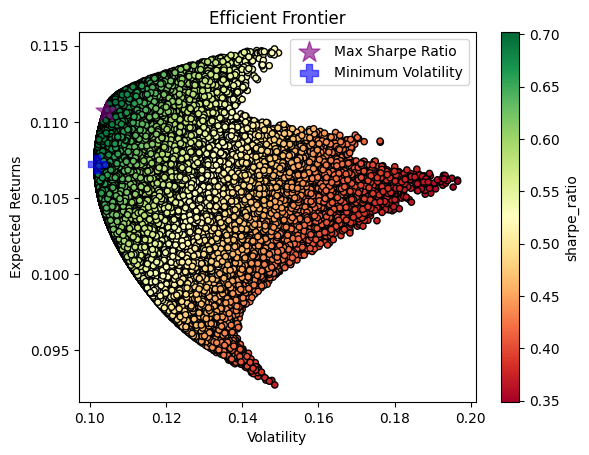

In [7]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
           y=max_sharpe_portf.returns,
           c='purple', marker='*',
           alpha=0.6,
           s=250, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
           y=min_vol_portf.returns,
           c='blue', marker='P',
           alpha=0.6,
           s=150, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.legend()

In [ ]:
# PyPortfolioOpt portfolio optimizations

from pypfopt import EfficientSemivariance
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return


# df_prices is a DataFrame of historical prices
mu = mean_historical_return(portfolio.daily_price_history)
S = CovarianceShrinkage(portfolio.daily_price_history).ledoit_wolf()

ef_min_vol = EfficientFrontier(mu, S)
ef_min_vol.min_volatility()
pyportfolio_min_vol_weights = ef_min_vol.clean_weights()
print(ef_min_vol.portfolio_performance(verbose=True))
print()

es = EfficientSemivariance(mu, portfolio.daily_price_history)
# Minimize semivariance (downside deviation)
es.min_semivariance()
pyportfolio_min_semivariance_weights = es.clean_weights()
print(pyportfolio_min_semivariance_weights)
print(es.portfolio_performance(verbose=True))
print()

ef_max_sharpe = EfficientFrontier(mu, S)
ef_max_sharpe.max_sharpe(RISK_FREE_RATE)
pyportfolio_max_sharpe_weights = ef_max_sharpe.clean_weights() 
print(pyportfolio_max_sharpe_weights)
print(ef_max_sharpe.portfolio_performance(verbose=True))
print()


C:\Users\Pandelus\AppData\Roaming\Python\Python313\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


Expected annual return: 11.4%
Annual volatility: 10.1%
Sharpe Ratio: 1.13
(np.float64(0.1143086238620206), np.float64(0.1007800691552897), np.float64(1.1342383947552672))

OrderedDict({'YFS Argonaut Absolute Return I GBP Acc': 0.03722, 'WisdomTree Physical Gold GBP Daily Hdgd': 0.14355, 'iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP': 0.11978, 'FAST - Global Fund Y-PF-ACC-GBP': 0.69945})
Expected annual return: 11.1%
Annual semi-deviation: 0.0%
Sortino Ratio: inf
(np.float64(0.11106668092945608), np.float64(0.0), np.float64(inf))

OrderedDict({'YFS Argonaut Absolute Return I GBP Acc': 0.31576, 'WisdomTree Physical Gold GBP Daily Hdgd': 0.44357, 'iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP': 0.02008, 'FAST - Global Fund Y-PF-ACC-GBP': 0.2206})
Expected annual return: 11.9%
Annual volatility: 10.4%
Sharpe Ratio: 0.78
(np.float64(0.1189652534463867), np.float64(0.10379008471806192), np.float64(0.7849040076196201))



C:\Users\Pandelus\AppData\Roaming\Python\Python313\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:149: UserWarning: Removing NaNs from returns
  warnings.warn(
C:\Users\Pandelus\AppData\Roaming\Python\Python313\site-packages\pypfopt\efficient_frontier\efficient_semivariance.py:272: RuntimeWarning: divide by zero encountered in scalar divide
  sortino_ratio = (mu - risk_free_rate) / semi_deviation
C:\Users\Pandelus\AppData\Roaming\Python\Python313\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


[Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 Text(0.5, 1.0, 'Efficient Frontier')]

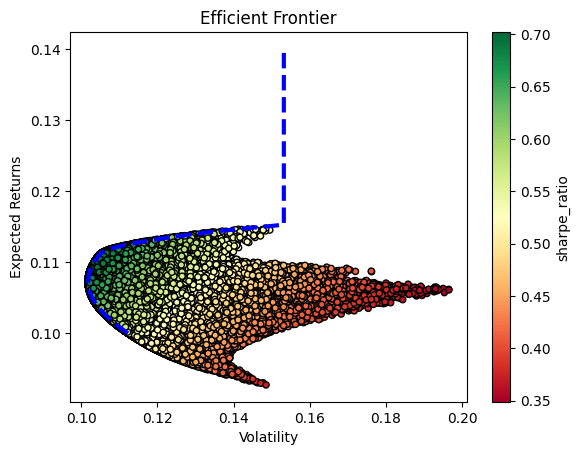

In [9]:
import scipy.optimize as sco

def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)
def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    efficient_portfolios = []
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    for ret in rtns_range:
        constraints = ({'type': 'eq',
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq',
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol,
                                           initial_guess,
                                           args=args,
                                           method='SLSQP',
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios

rtns_range = np.linspace(start=0.10, stop=0.14, num=200)

efficient_portfolios = get_efficient_frontier(avg_returns, cov_mat, rtns_range)

#Extract the volatilities of the efficient portfolios:
vols_range = [x['fun'] for x in efficient_portfolios]

#Plot the calculated Efficient Frontier, together with the simulated portfolios
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')


In [10]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']
min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': (min_vol_portf_rtn /
                                  min_vol_portf_vol)}

print('Minimum volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
   print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(fund_names, efficient_portfolios[min_vol_ind]['x']):
   print(f'{100*y:.2f}% {x}\n', end="", flush=True)   

Minimum volatility portfolio ----
Performance
Return: 10.72% Volatility: 10.18% Sharpe Ratio: 105.31% 
Weights
29.87% YFS Argonaut Absolute Return I GBP Acc
31.94% WisdomTree Physical Gold GBP Daily Hdgd
19.07% iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP
19.11% FAST - Global Fund Y-PF-ACC-GBP


In [11]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

n_assets = len(avg_returns)
RF_RATE = 0
args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]
max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                x0=initial_guess,
                                args=args,
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)

max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w,
                                                avg_returns,
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

print('---- Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')

weights = max_sharpe_portf_w

for x, y in zip(fund_names, weights):
   print(f'{100*y:.2f}% {x}\n', end="", flush=True)   
  

---- Maximum Sharpe Ratio portfolio ----
Performance
Return: 10.95% Volatility: 10.29% Sharpe Ratio: 106.44% 
Weights
30.57% YFS Argonaut Absolute Return I GBP Acc
40.07% WisdomTree Physical Gold GBP Daily Hdgd
7.81% iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP
21.54% FAST - Global Fund Y-PF-ACC-GBP


In [12]:
import plotly.express as plot

graph_prices = portfolio.daily_price_history
names_with_weights = []
weight_colours=[]

weights = list(pyportfolio_max_sharpe_weights.values())

for i in range(len(graph_prices.columns)):
    percentage = weights[i]*100.0
    fund_name = portfolio.fund_selection[i].name
    names_with_weights.append(f"{round(percentage,2)}% - {fund_name}")
    colour = ColorHash(fund_name, lightness=[0.25]).hex
    weight_colours.append(colour)

# Add total to graph
#print(graph_prices.dot(weights))
graph_prices['Highest Sharpe Ratio for given return portfolio'] = graph_prices.dot(weights)
#names_with_weights.append(f'Highest Sharpe Ratio for given return portfolio {best_result.annual_return*100.0:.2f}% return')
names_with_weights.append(f'Highest Sharpe Ratio for given return portfolio')
weight_colours.append("yellow")

# Add benchmark to graph
benchmark_prices = portfolio.get_benchmark_daily_price_history()
graph_prices['Benchmark (4PHUXACHE)'] = benchmark_prices
names_with_weights.append(f'Benchmark (4PHUXACHE)')
weight_colours.append("orange")

graph_prices.columns = names_with_weights

fig = plot.line(graph_prices, x=graph_prices.index, y=graph_prices.columns, 
                #title=f"Lowest Max Drawdown ({round(best_result.max_drawdown*100,3)}%) portfolio for {best_result.annual_return*100.0:.2f}% annualised return, min {MIN_ALLOCATION*100.0:.1f}% allocation, max {MAX_ALLOCATION*100.0:.1f}% allocation",
                labels={'value': 'Price', 'variable': 'Instrument'},
                template='plotly_dark',
                color_discrete_sequence=weight_colours
                )
fig.update_layout(autosize=False, width=1600, height=800 )
fig.show()
